In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor

from warnings import filterwarnings
filterwarnings('ignore')

In [4]:
basket = pd.read_csv("Market_Basket_Optimisation.csv", header=None, names=[f"item{idx}" for idx in range(1,21)])
df = basket.copy()
df

,item1,item2,item3,item4,item5,item6,item7,item8,item9,item10,item11,item12,item13,item14,item15,item16,item17,item18,item19,item20
0,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
1,burgers,meatballs,eggs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chutney,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,turkey,avocado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mineral water,milk,energy bar,whole wheat rice,green tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7496,butter,light mayo,fresh bread,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7497,burgers,frozen vegetables,eggs,french fries,magazines,green tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7498,chicken,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7499,escalope,green tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.shape

(7501, 20)

# Veri Temizleme Adımları

In [7]:
all_products = df.melt()["value"].dropna().sort_values()
all_products

53201     asparagus
41879       almonds
16444       almonds
28148       almonds
29316       almonds
            ...    
54568      zucchini
35183      zucchini
36954      zucchini
62439      zucchini
28412      zucchini
Name: value, Length: 29363, dtype: object

In [8]:
# Başlangıç veya bitişinde boşluk karakteri olan örnekler.
all_products[all_products.str.contains("^\s|\s$")].to_list()

[' asparagus']

In [9]:
df.replace(" asparagus", "asparagus", inplace=True)

In [10]:
all_products.replace(" asparagus", "asparagus", inplace=True)

In [15]:
# Bütün ürünler listesindeki unique değer sayısı.
all_products.nunique()

119

# Keşifçi Veri Analizi

Text(0, 0.5, 'İşlem Sayısı')

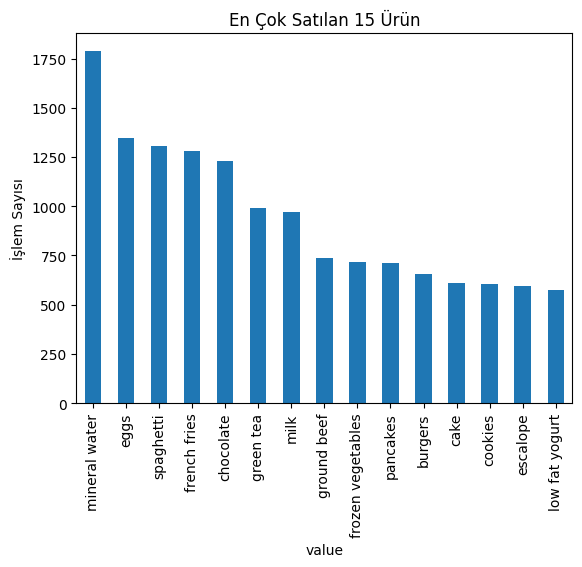

In [22]:
item_counts = all_products.value_counts()

ax = item_counts.nlargest(15).plot(kind="bar", title="En Çok Satılan 15 Ürün")
ax.set_ylabel("İşlem Sayısı")

Text(0, 0.5, 'İşlem Sayısı')

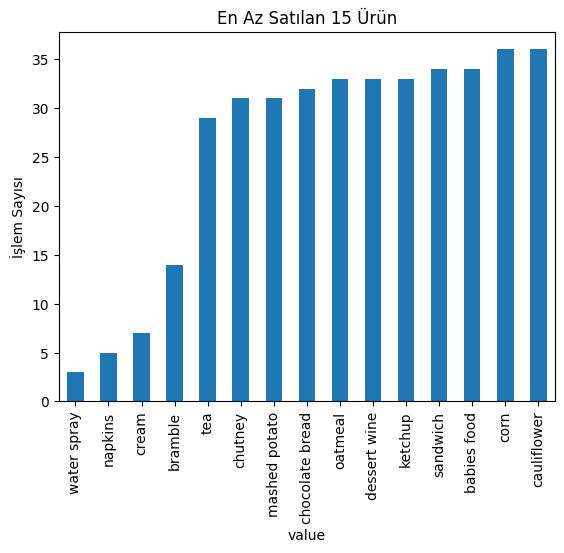

In [23]:
ax = item_counts.nsmallest(15).plot(kind="bar", title="En Az Satılan 15 Ürün")
ax.set_ylabel("İşlem Sayısı")

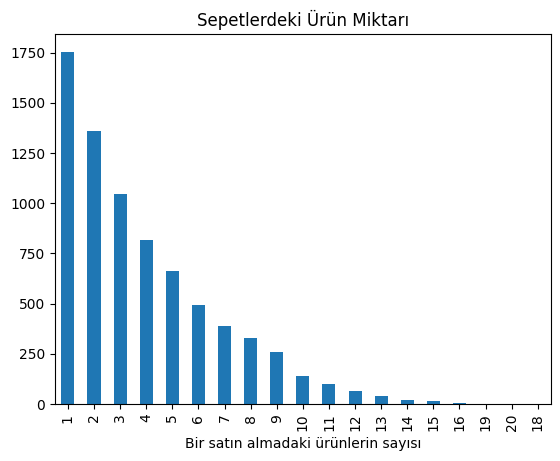

In [26]:
basket_sizes = df.notna().apply(sum, axis = 1)

ax = basket_sizes.value_counts().plot.bar(title = "Sepetlerdeki Ürün Miktarı")

ax.set_xlabel("Bir satın almadaki ürünlerin sayısı");

In [41]:
# Grafiğe göre bir alışverişte 17 adet ürün alan sepetin olmadığını doğruluyoruz.
basket_sizes[(basket_sizes == 17)]

Series([], dtype: int64)

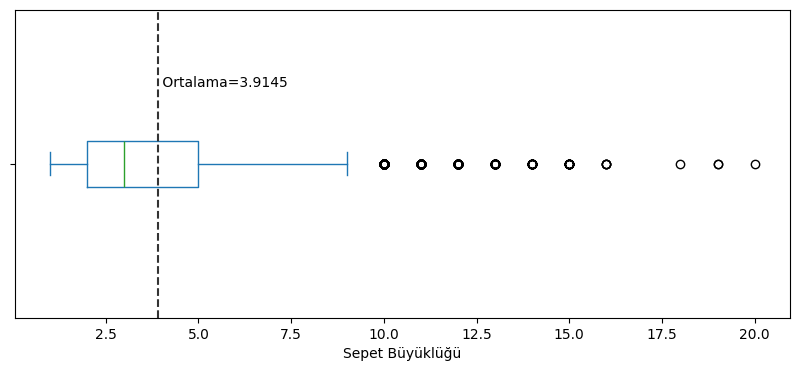

In [49]:
avg_basket_size = basket_sizes.mean()

ax = basket_sizes.plot.box(vert = False, figsize = (10, 4))
ax.axvline(avg_basket_size, 0, 1, linestyle="--", label="mean", color="#333")
ax.text(avg_basket_size, 1.25, f" Ortalama={avg_basket_size:.4f}")
ax.set_xlabel("Sepet Büyüklüğü")
ax.set_yticklabels([]);

In [53]:
basket_sizes.describe()

count    7501.000000
mean        3.914545
std         2.905540
min         1.000000
25%         2.000000
50%         3.000000
75%         5.000000
max        20.000000
dtype: float64

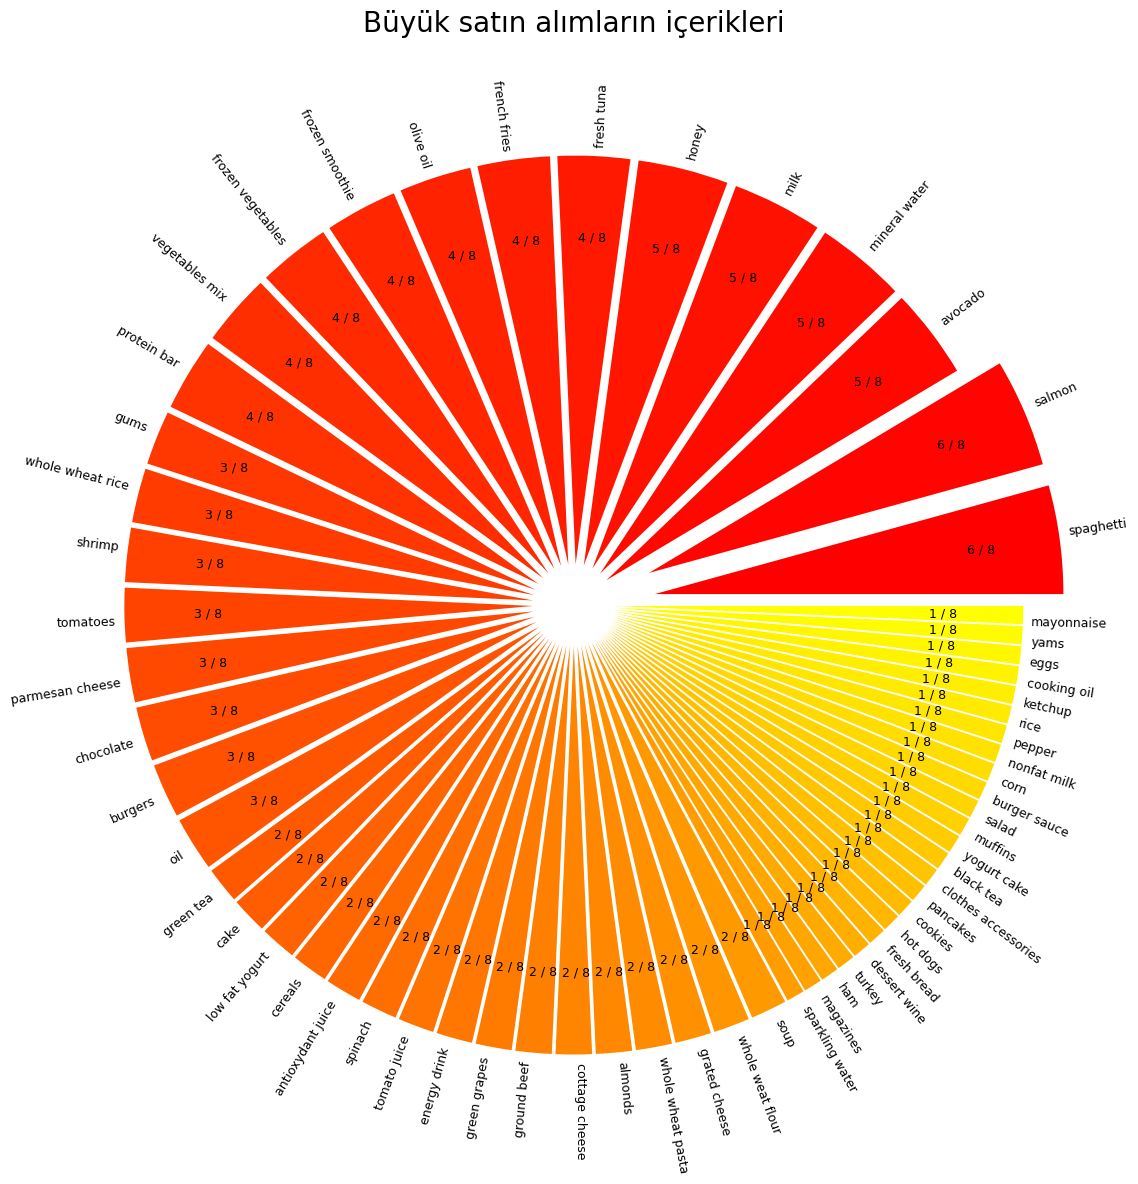

In [65]:
# 20'nin %75'i olan 15 değerini eşik değer kabul ettik. 15'ten fazla ürün alan sepetler büyük olarak nitelendirilecek
items_in_largest_transactions = df[basket_sizes > 15].melt()["value"].dropna()

pie_data = items_in_largest_transactions.value_counts()
ax = pie_data.plot.pie(
    cmap="autumn",
    explode=[0.2] * 2 + [0.1] * 59,
    figsize=(12, 12),
    autopct=lambda pct: f" {pct * 0.01 * pie_data.sum():.0f} / {len(df[basket_sizes > 15])}",
    pctdistance=0.8,
    labeldistance=1.02,
    rotatelabels=True,
    textprops={"size": 9},
)
ax.set_title("Büyük satın alımların içerikleri", size=20, pad=45)
ax.set_ylabel("")
ax.figure.tight_layout()

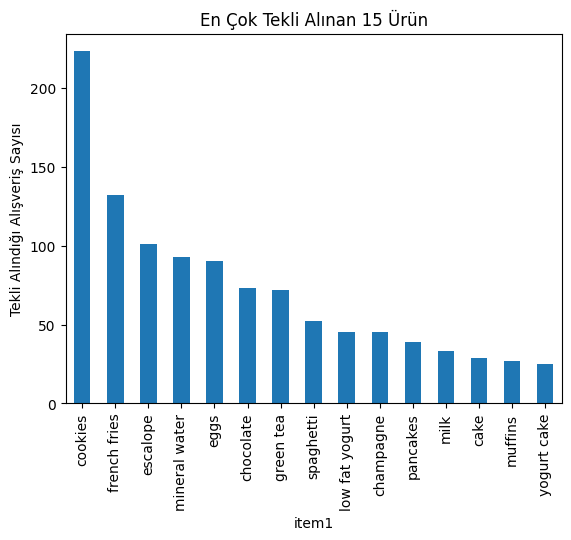

In [73]:
single_items = df[basket_sizes == 1]["item1"].value_counts()
ax = single_items.head(15).plot.bar()
ax.set_title("En Çok Tekli Alınan 15 Ürün")
ax.set_ylabel("Tekli Alındığı Alışveriş Sayısı");

# Birliktelik Analizi

In [76]:
baskets = [tuple(row.dropna()) for _, row in df[basket_sizes > 1].iterrows()]
baskets[-5:]

[('pancakes', 'light mayo'),
 ('butter', 'light mayo', 'fresh bread'),
 ('burgers',
  'frozen vegetables',
  'eggs',
  'french fries',
  'magazines',
  'green tea'),
 ('escalope', 'green tea'),
 ('eggs', 'frozen smoothie', 'yogurt cake', 'low fat yogurt')]

In [90]:
from efficient_apriori import apriori

item_sets, association_rules = apriori(baskets, min_support=0.05, min_confidence=0.1)

one_to_one_rules = filter(
    lambda rule: len(rule.lhs) == 1 and len(rule.rhs) == 1, association_rules
)
for rule in sorted(one_to_one_rules, key=lambda rule: rule.lift):
    print(rule)


{mineral water} -> {eggs} (conf: 0.225, supp: 0.066, lift: 1.030, conv: 1.008)
{eggs} -> {mineral water} (conf: 0.304, supp: 0.066, lift: 1.030, conv: 1.013)
{mineral water} -> {chocolate} (conf: 0.233, supp: 0.069, lift: 1.159, conv: 1.042)
{chocolate} -> {mineral water} (conf: 0.342, supp: 0.069, lift: 1.159, conv: 1.071)
{spaghetti} -> {chocolate} (conf: 0.234, supp: 0.051, lift: 1.166, conv: 1.043)
{chocolate} -> {spaghetti} (conf: 0.254, supp: 0.051, lift: 1.166, conv: 1.048)
{spaghetti} -> {mineral water} (conf: 0.357, supp: 0.078, lift: 1.211, conv: 1.097)
{mineral water} -> {spaghetti} (conf: 0.264, supp: 0.078, lift: 1.211, conv: 1.063)
{mineral water} -> {milk} (conf: 0.212, supp: 0.063, lift: 1.300, conv: 1.062)
{milk} -> {mineral water} (conf: 0.383, supp: 0.063, lift: 1.300, conv: 1.143)
{mineral water} -> {ground beef} (conf: 0.181, supp: 0.053, lift: 1.454, conv: 1.069)
{ground beef} -> {mineral water} (conf: 0.429, supp: 0.053, lift: 1.454, conv: 1.234)
{spaghetti} -> {